# MRI reconstruction from singlecoil data

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os
import sigpy.mri as mr

import sigpy as sp
import sigpy.mri as mr
from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

from include import *

from PIL import Image
import PIL
import h5py
#from skimage.metrics import structural_similarity as ssim
from common.evaluate import *
from pytorch_msssim import ms_ssim
import pickle
from common.subsample import MaskFunc

from DIP_UNET_models.unet_and_tv.train_unet import UnetMRIModel

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
#from models import *
#from utils.denoising_utils import *

# from facebook MRI
#import transforms
from include import transforms as transform

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    #os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    gpu = 0
    torch.cuda.set_device(gpu)
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


In [2]:
import nibabel as nib
path= 'HCP_mgh_1001_MR_MPRAGE_GradWarped_and_Defaced_Br_20140919084711597_S227198_I444246.nii'
img = nib.load(path)
img_data = img.get_data()
img_data_arr = np.asarray(img_data)
img_data_arr = img_data_arr.astype(np.float32)
kspace_np = np.zeros(img_data_arr.shape,dtype='complex')
#kspace = torch.from_numpy(kspace)
for i in range(img_data_arr.shape[2]):
    fft_img_np = np.fft.fft2(img_data_arr[:,:,i],norm="ortho")
    kspace_np[:,:,i] = np.fft.fftshift(fft_img_np) 

Kspace shape (x, y, number slices, number coils):  ((256, 256, 176), 1)


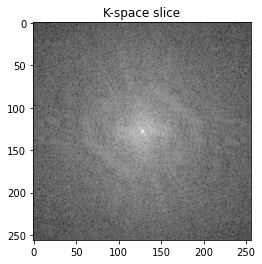

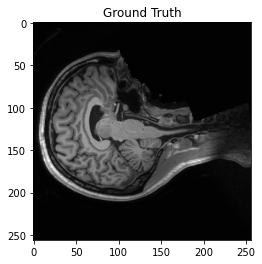

In [3]:
slicenu = 88-5
slice_ksp = kspace_np[:,:,slicenu]
plt.imshow(20*np.log(np.abs(slice_ksp)),cmap='gray')
plt.title('K-space slice')
plt.figure()
plt.imshow(img_data_arr[:,:,slicenu],cmap='gray')
plt.title('Ground Truth')
print("Kspace shape (x, y, number slices, number coils): ", (kspace_np.shape ,1))

In [4]:
slice_ksp = slice_ksp[np.newaxis,:]
slice_ksp_torchtensor = transform.to_tensor(slice_ksp)
slice_image = transform.ifft2(slice_ksp_torchtensor)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = transform.complex_abs(slice_image) 

In [5]:
torch.cuda.empty_cache()

In [6]:
numit = 25000
LR = 0.008

In [8]:
output_depth = slice_ksp.shape[0]*2
out_size = slice_ksp.shape[1:]

arch_name = "DD"
###
num_channels = 256
num_layers = 10
in_size = [16,16]

net = skipdecoder(out_size,in_size,output_depth,
                   num_layers,num_channels,skips=False,need_last=True,
                   need_sigmoid=False,upsample_mode="bilinear").type(dtype)
print("#parameters of {}:".format(arch_name),num_param(net))
#print(net)

[(22, 22), (30, 30), (41, 41), (55, 55), (75, 75), (102, 102), (139, 139), (189, 189), (256, 256)]
#parameters of DD: 660992


In [9]:
### fixing the scaling (note that it can be done using the under-sampled kspace as well, but we do it using the full kspace)
scale_out = 1
scaling_factor,ni = get_scale_factor(net,
                                   num_channels,
                                   in_size,
                                   slice_ksp,
                                   scale_out=scale_out)

torch.Size([1, 256, 256, 2])


In [10]:
scaling_factor

0.016694887743636616

In [11]:
slice_ksp_torchtensor = slice_ksp_torchtensor * scaling_factor
slice_ksp = slice_ksp * scaling_factor

In [12]:
try: # if the file already has a mask
    temp = np.array([1 if e else 0 for e in f["mask"]])
    temp = temp[np.newaxis].T
    temp = np.array([[temp]])
    mask = transform.to_tensor(temp).type(dtype).detach().cpu()
except: # if we need to create a mask
    desired_factor = 4 # desired under-sampling factor
    undersampling_factor = 0
    tolerance = 0.03
    while undersampling_factor < desired_factor - tolerance or undersampling_factor > desired_factor + tolerance:
        mask_func = MaskFunc(center_fractions=[0.07], accelerations=[desired_factor])  # Create the mask function object
        masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor, mask_func=mask_func)   # Apply the mask to k-space
        mask1d = var_to_np(mask)[0,:,0]
        undersampling_factor = len(mask1d) / sum(mask1d)

mask1d = var_to_np(mask)[0,:,0]

# The provided mask and data have last dim of 368, but the actual data is smaller.
# To prevent forcing the network to learn outside the data region, we force the mask to 0 there.
mask1d[:mask1d.shape[-1]//2-128] = 0 
mask1d[mask1d.shape[-1]//2+128:] =0
mask2d = np.repeat(mask1d[None,:], slice_ksp.shape[1], axis=0).astype(int) # Turning 1D Mask into 2D that matches data dimensions
mask2d = np.pad(mask2d,((0,),((slice_ksp.shape[-1]-mask2d.shape[-1])//2,)),mode='constant') # Zero padding to make sure dimensions match up
mask = transform.to_tensor( np.array( [[mask2d[0][np.newaxis].T]] ) ).type(dtype).detach().cpu()

In [13]:
print("under-sampling factor",len(mask1d)/sum(mask1d))

under-sampling factor 4.0


In [14]:
masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor, mask = mask)
unders_measurement = np_to_var( masked_kspace.data.cpu().numpy() ).type(dtype)
sampled_image2 = transform.ifft2(masked_kspace)

In [15]:
##### input normalization for U-net
# Crop input image to given resolution if larger
smallest_width = min(320, sampled_image2.shape[-2])
smallest_height = min(320, sampled_image2.shape[-3])

crop_size = (smallest_height, smallest_width)
sampled_image = transform.complex_center_crop(sampled_image2, crop_size)
# Absolute value
sampled_image = transform.complex_abs(sampled_image)
# Apply Root-Sum-of-Squares if multicoil data
sampled_image = transform.root_sum_of_squares(sampled_image)
# Normalize input
sampled_image, mean, std = transform.normalize_instance(sampled_image, eps=1e-11)
sampled_image = sampled_image.clamp(-6, 6)

In [16]:
measurement = ksp2measurement(slice_ksp).type(dtype)

In [17]:
# reconstruct from full kspace measurement with build-in function
slice_image_rss = transform.root_sum_of_squares(slice_image_abs, dim=0)

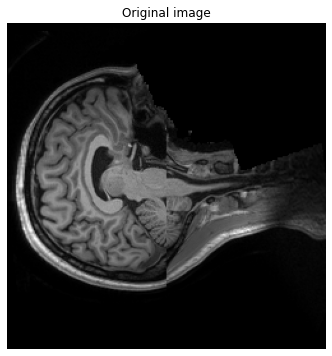

In [18]:
lsimg = lsreconstruction(measurement)
lsrec = crop_center2( root_sum_of_squares2(var_to_np(lsimg)) , 250,256)

fig = plt.figure(figsize = (6,6)) # create a 6 x 6 figure 
ax1 = fig.add_subplot(111)
ax1.imshow(np.fft.ifftshift(lsrec),cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')
plt.show()

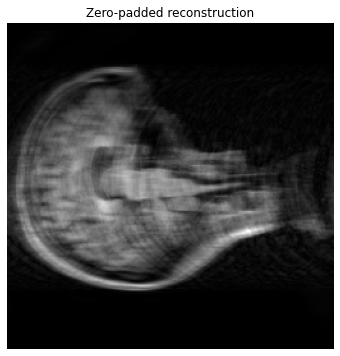

In [19]:
sampled_image_tensor = transforms.ifftshift((sampled_image))
sampled_image_np = sampled_image_tensor.detach().cpu().numpy()

fig = plt.figure(figsize = (6,6)) 
ax1 = fig.add_subplot(111)
ax1.imshow(sampled_image_np,cmap='gray')
ax1.set_title('Zero-padded reconstruction')
ax1.axis('off')
plt.show()

In [35]:
# normalization before computing the scores
im2 = sampled_image_np
im1 = img_data_arr[:,:,slicenu]
im1 = (im1-im1.mean()) / im1.std()
im1 *= im2.std()
im1 += im2.mean()

In [36]:
vif_noisy = vifp_mscale(im1,im2,sigma_nsq=im1.mean())

In [37]:
ssim_noisy = ssim(np.array([im1]), np.array([im2]))
psnr_noisy = psnr(np.array([im1]),np.array([im2]))

dt = torch.FloatTensor
im11 = torch.from_numpy(np.array([[im1]])).type(dt)
im22 = torch.from_numpy(np.array([[im2]])).type(dt)
ms_ssim_noisy = ms_ssim(im11, im22,data_range=im22.max()).data.cpu().numpy()[np.newaxis][0]

In [21]:
num_param(net)

660992

In [22]:
out = []
for img in sampled_image2:
    out += [ img[:,:,0].numpy() , img[:,:,1].numpy() ]
lsest = torch.tensor(np.array([out]))

In [23]:
scale_out=1

In [24]:
from demo_helper import helpers

def fft2(data):
  data = helpers.fft2(data)
  return data


def ifft2(data):
  data = helpers.ifft2(data)
  return data

def forwardm_me(img,mask):
    # img has dimension (2*num_slices, x,y)
    # output has dimension (1, num_slices, x, y, 2)
    mask = np_to_var(mask)[0].type(dtype)
    s = img.shape
    ns = int(s[1]/2) # number of slices
    fimg = Variable( torch.zeros( (s[0],ns,s[2],s[3],2 ) ) ).type(dtype)
    for i in range(ns):
        fimg[0,i,:,:,0] = img[0,2*i,:,:]
        fimg[0,i,:,:,1] = img[0,2*i+1,:,:]
    Fimg = fft2(fimg) # dim: (1,num_slices,x,y,2)
    for i in range(ns):
        Fimg[0,i,:,:,0] *= mask
        Fimg[0,i,:,:,1] *= mask
    return Fimg

In [26]:
scale_out,sover,pover,norm_ratio,par_mse_n, par_mse_t, parni, parnet = fit( in_size = in_size,
                                                                num_channels=[num_channels]*(num_layers-1),
                                                                num_iter=numit,
                                                                LR=LR,
                                                                mask = mask2d,
                                                                apply_f = forwardm_me,
                                                                img_noisy_var=unders_measurement,
                                                                net=net,
                                                                upsample_mode="free",
                                                                img_clean_var=Variable(lsest).type(dtype),
                                                                lsimg = lsimg,
                                                                find_best=True,
                                                                loss_type="MSE",
                                                                scale_out=scale_out,
                                                                net_input = ni,
                                                                OPTIMIZER = "adam"
                                                                          )

input provided
optimize with adam 0.008


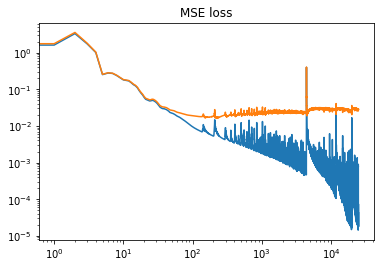

In [27]:
plt.loglog(par_mse_n)
plt.loglog(par_mse_t)
plt.title("MSE loss")
plt.show()

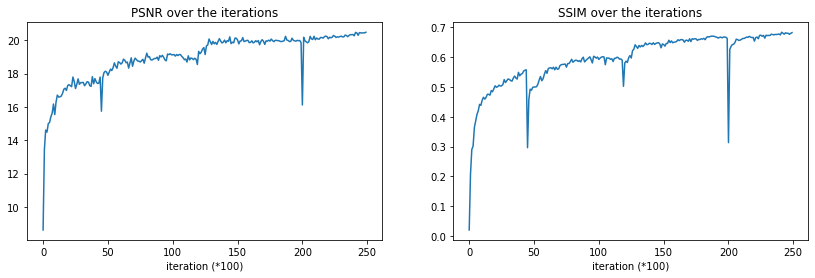

In [28]:
fig = plt.figure(figsize = (14,4)) # create a 5 x 5 figure 
    
ax1 = fig.add_subplot(121)
ax1.plot(pover)
ax1.set_title('PSNR over the iterations')
ax1.set_xlabel("iteration (*100)")

ax2 = fig.add_subplot(122)
ax2.plot(sover)
ax2.set_title( "SSIM over the iterations" )
ax2.set_xlabel("iteration (*100)")

plt.show()

In [29]:
img = parnet(parni.type(dtype))
s = img.shape
ns = int(s[1]/2) # number of slices
fimg = Variable( torch.zeros( (s[0],ns,s[2],s[3],2 ) ) ).type(dtype)
for i in range(ns):
    fimg[0,i,:,:,0] = img[0,2*i,:,:]
    fimg[0,i,:,:,1] = img[0,2*i+1,:,:]
Fimg = transform.fft2(fimg) # dim: (1,num_slices,x,y,2)
# ksp has dim: (num_slices,x,y)
meas = ksp2measurement(slice_ksp) # dim: (1,num_slices,x,y,2)
meas = meas.float()
mask = torch.from_numpy(np.array(mask1d, dtype=np.uint8))
ksp_dc = Fimg.clone()
ksp_dc = ksp_dc.detach().cpu()
ksp_dc[:,:,:,mask==1,:] = meas[:,:,:,mask==1,:] # after data consistency block

img_dc = transform.ifft2(ksp_dc)[0]
out = []
for img in img_dc.detach().cpu():
    out += [ img[:,:,0].numpy() , img[:,:,1].numpy() ]

par_out_chs = np.array(out)
#par_out_chs = parnet( parni.type(dtype),scale_out=scale_out ).data.cpu().numpy()[0]
par_out_imgs = channels2imgs(par_out_chs)

prec = crop_center2(root_sum_of_squares2(par_out_imgs),256,256)

In [30]:
prec_tensor = transforms.ifftshift(transforms.to_tensor(prec))
prec_np = prec_tensor.detach().cpu().numpy()

In [31]:
# normalization before computing the scores
im2 = prec_np.copy()
im1 = img_data_arr[:,:,slicenu]
im1 = (im1-im1.mean()) / im1.std()
im1 *= im2.std()
im1 += im2.mean()

In [32]:
vif_ = vifp_mscale(im1,im2,sigma_nsq=im1.mean())

In [33]:
ssim_ = ssim(np.array([im1]), np.array([im2]))
psnr_ = psnr(np.array([im1]),np.array([im2]))

dt = torch.FloatTensor
im11 = torch.from_numpy(np.array([[im1]])).type(dt)
im22 = torch.from_numpy(np.array([[im2]])).type(dt)
ms_ssim_ = ms_ssim(im11, im22,data_range=im22.max()).data.cpu().numpy()[np.newaxis][0]

In [38]:
print("Noisy --> VIF: %.2f, MS-SSIM: %.2f, SSIM: %.2f, PSNR: %.2f " % (vif_noisy,ms_ssim_noisy,ssim_noisy,psnr_noisy))
print("DeepDecoder --> VIF: %.2f, MS-SSIM: %.2f, SSIM: %.2f, PSNR: %.2f " % (vif_,ms_ssim_,ssim_,psnr_))

Noisy --> VIF: 0.07, MS-SSIM: 0.88, SSIM: 0.72, PSNR: 23.12 
DeepDecoder --> VIF: 0.79, MS-SSIM: 0.94, SSIM: 0.86, PSNR: 28.26 


(-0.5, 255.5, 255.5, -0.5)

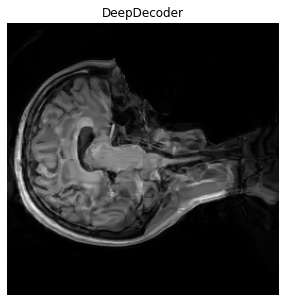

In [41]:
fig = plt.figure(figsize = (5,5))
ax2 = fig.add_subplot(111)
ax2.imshow(prec_np,cmap='gray')
ax2.set_title( "DeepDecoder") 
ax2.axis('off') 


In [43]:
torch.save(parni,'C:/Users/user/Desktop/MS_Sem2/ML/ML Project/ConvDecoder/model_input_DD.pth')
torch.save(parnet,'C:/Users/user/Desktop/MS_Sem2/ML/ML Project/ConvDecoder/full_model_DD.pth')
np.save('C:/Users/user/Desktop/MS_Sem2/ML/ML Project/ConvDecoder/mask_DD.npy',mask1d)